1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


0.9902619585935334
0.9959999999999998


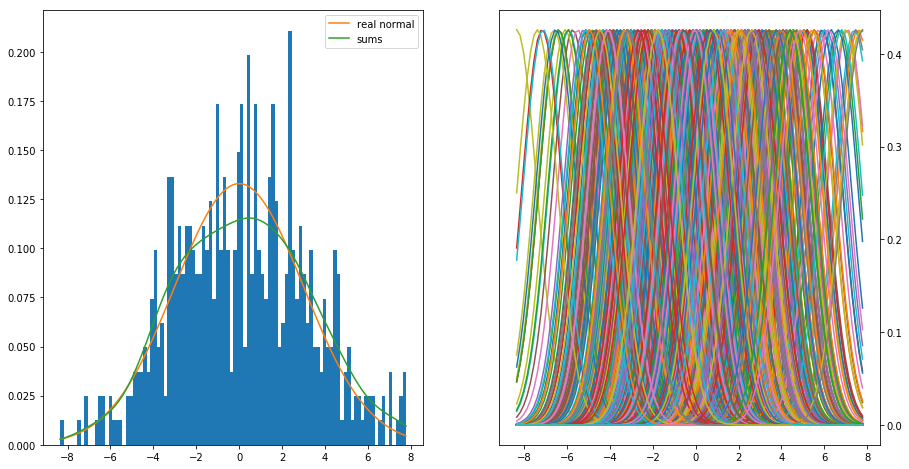

In [3]:
import math
import matplotlib.mlab as mlab
import numpy
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import trapz
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
%matplotlib inline

mu , sigma = 0, 3
s = np.random.normal(mu,sigma,500)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15, 8))
count, bins, ignored = ax1.hist(s, 100,density=True)
y = norm.pdf(bins, mu, sigma)
ax1.plot(bins, y, label = 'real normal')

gaussians = np.array([norm.pdf(bins, i, 1.06*s.std()*math.pow(s.size,-1/5)) for i in s])
for gaussian in gaussians:
    ax2.plot(bins, gaussian,)
sums = np.sum(gaussians, axis = 0)/500

ax1.plot(bins, sums, label = 'sums')
ax1.legend(loc='best')
ax2.yaxis.tick_right()
plt.plot()
print(trapz(sums, bins))
print(trapz(count, bins[:-1]))


2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

/home/federico/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


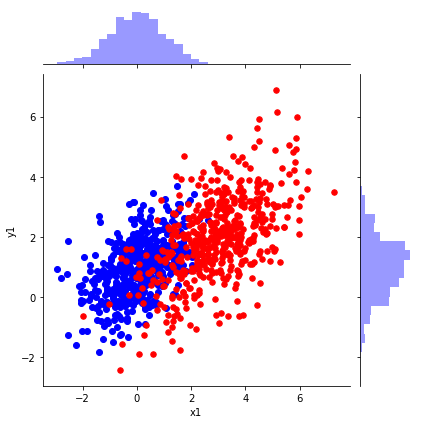

In [4]:
import pandas as pd
import seaborn as sns

mean1, cov1 = [0, 1], [(1, .5), (.5, 1)]
mean2, cov2 = [3, 2], [(2, 1), (1, 2)]
data1 = np.random.multivariate_normal(mean1, cov1, 500)
data2 = np.random.multivariate_normal(mean2, cov2, 500)
df1 = pd.DataFrame(data1, columns=['x1', 'y1'])
df2 = pd.DataFrame(data2, columns=['x2', 'y2'])

graph = sns.jointplot(x=df1.x1, y=df1.y1, color='b')

graph.x = df2.x2
graph.y = df2.y2
graph.plot_joint(plt.scatter,marker='o', c='r', s=30)

--2019-03-13 20:08:51--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [segue]
--2019-03-13 20:08:52--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc548facc445d4ce4c0ba1002c72.dl.dropboxusercontent.com/cd/0/inline/AdDo0PkBQjH0s3o-SrpJ2TGnI6ybftsxcHtV_JwmZL_qyYhzGGDlp45ULWsTkwqqbFmpYRIZoMiqLHn4UarVuZ8Ys0qhjN61VszaZT0vbnarCyKab5WilPoHY_vZC15wi-0/file# [segue]
--2019-03-13 20:08:52--  https://uc548facc445d4ce4c0ba1002c72.dl.dropboxusercontent.com/cd/0/inline/AdDo0PkBQjH0s3o-SrpJ2TGnI6ybftsxcHtV_JwmZL_qyYhzGGDlp45U

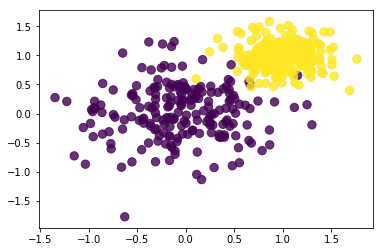

In [5]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')


3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [6]:
! wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2019-03-13 20:08:55--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [segue]
--2019-03-13 20:08:56--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc94b4c85fa0a89debacec4c4032.dl.dropboxusercontent.com/cd/0/inline/AdBj9UOzSWfeKoGZ4XL5Vr68rGrDperEIZzqNWpeI6jWe0vfP5nkJFlj-SQUJ9TojhxB0FQHqfuxyfjnaCtiYAxAb0iLvLfuZos20ZYJnfCWsNU5PRXGUxD4PmjQkpckN2o/file# [segue]
--2019-03-13 20:08:56--  https://uc94b4c85fa0a89debacec4c4032.dl.dropboxusercontent.com/cd/0/inline/AdBj9UOzSWfeKoGZ4XL5Vr68rGrDperEIZzqNWpeI6jWe0vfP5nkJFlj-SQUJ9TojhxB0FQHqfuxyfjnaCtiYAxAb0iLvLfuZo

In [7]:
data = pd.DataFrame(np.load("residuals_261.npy").item())


In [8]:
data = data[abs(data['residuals']) < 2]


In [9]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(data['residuals'], data['distances'])

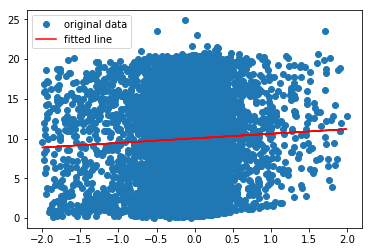

In [10]:
plt.plot(data['residuals'], data['distances'], 'o', label='original data')
plt.plot(data['residuals'], intercept + slope*data['residuals'], 'r', label='fitted line')
plt.legend()
plt.show()

<ErrorbarContainer object of 3 artists>

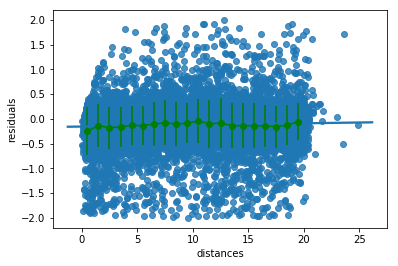

In [11]:
sns.regplot(x = data['distances'],y=data['residuals'])
nbin=20 #this is the number of blue points with the error bar
bin_edges = np.linspace(0,20,nbin+1)
central_points =(bin_edges[1:] + bin_edges[:-1])/2

y=np.array([data.loc[(data['distances'] >=bin_edges[i]) & (data['distances'] <bin_edges[i+1])]['residuals'].mean() for i in range(nbin)])
erry=np.array([data.loc[(data['distances'] >=bin_edges[i]) & (data['distances'] <bin_edges[i+1])]['residuals'].std() for i in range(nbin)])
plt.errorbar(central_points,y,yerr=erry, label='Profile Plot',linewidth=1.5,color='green',marker='o')